### Importing Necessary Libraries

In [63]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAvgPool2D, BatchNormalization
from tensorflow.keras.regularizers import l2

from tensorflow.keras.optimizers import Adam

from sklearn.metrics import precision_recall_fscore_support as score

## Data

A detailed discussion and visualization of the data can be seen in [here](Data-Overview.ipynb).

In [64]:
labels = pd.read_csv("./Data/train_labels.csv")
images = ['./Data/train/train/'+str(name)+'.tif' for name in labels['id']]
labels['images'] = images
labels = labels[['id', 'images', 'label']]

In [65]:
labels

,id,images,label
0,0,./Data/train/train/0.tif,1
1,1,./Data/train/train/1.tif,13
2,2,./Data/train/train/2.tif,13
3,3,./Data/train/train/3.tif,14
4,4,./Data/train/train/4.tif,6
...,...,...,...
15995,15995,./Data/train/train/15995.tif,2
15996,15996,./Data/train/train/15996.tif,15
15997,15997,./Data/train/train/15997.tif,3
15998,15998,./Data/train/train/15998.tif,9


In [66]:
# test_labels = labels.sample(800).sort_values(by='id')
# labels = labels[~labels['id'].isin(list(test_labels['id']))]

In [67]:
# test_labels

In [68]:
# labels

In [69]:
# labels.to_csv('./Data/train_labels_1.csv', index=False)
# test_labels.to_csv('./Data/test_labels_1.csv', index=False)

In [70]:
train_labels = pd.read_csv('./Data/train_labels_1.csv')
test_labels = pd.read_csv('./Data/test_labels_1.csv')

In [71]:
train_labels

,id,images,label
0,0,./Data/train/train/0.tif,1
1,1,./Data/train/train/1.tif,13
2,2,./Data/train/train/2.tif,13
3,3,./Data/train/train/3.tif,14
4,4,./Data/train/train/4.tif,6
...,...,...,...
15195,15995,./Data/train/train/15995.tif,2
15196,15996,./Data/train/train/15996.tif,15
15197,15997,./Data/train/train/15997.tif,3
15198,15998,./Data/train/train/15998.tif,9


In [72]:
test_labels

,id,images,label
0,18,./Data/train/train/18.tif,11
1,25,./Data/train/train/25.tif,8
2,33,./Data/train/train/33.tif,6
3,41,./Data/train/train/41.tif,1
4,65,./Data/train/train/65.tif,14
...,...,...,...
795,15816,./Data/train/train/15816.tif,2
796,15824,./Data/train/train/15824.tif,2
797,15832,./Data/train/train/15832.tif,11
798,15863,./Data/train/train/15863.tif,15


In [73]:
class_labels = list(set(labels['label']))
class_names = [
    'letter', 'form', 'email', 'handwritten', 'advertisement', 'scientific report', 'scientific publication',
    'specification', 'file folder', 'news article', 'budget', 'invoice', 'presentation', 'questionnaire', 'resume',
    'memo'
]
label_names = pd.DataFrame({
    'labels': class_labels,
    'names': class_names
})

## Data Preparation

In [74]:
fine_tune_data = np.load('./Data/ResNet-4P-train-precompute/whole_train_data_precomp.npy')
fine_tune_data.shape

(16000, 5, 2048)

In [75]:
fine_tune_labels = labels['label'].to_numpy()
fine_tune_labels.shape

(16000,)

In [76]:
fine_tune_data_train = fine_tune_data[list(train_labels['id'])]
fine_tune_data_train.shape

(15200, 5, 2048)

In [77]:
fine_tune_labels_train = train_labels['label'].to_numpy()
fine_tune_labels_train.shape

(15200,)

In [78]:
fine_tune_data_test = fine_tune_data[list(test_labels['id'])]
fine_tune_data_test.shape

(800, 5, 2048)

In [79]:
fine_tune_labels_test = test_labels['label'].to_numpy()
fine_tune_labels_test.shape

(800,)

In [80]:
N_COMPS = 1600
pcas = [PCA(N_COMPS) for _ in range(5)]

In [81]:
for i in range(5):
    pcas[i].fit(fine_tune_data_train[:,i,:])

In [82]:
fine_tune_data_train_red = np.zeros((fine_tune_data_train.shape[0], 5, N_COMPS))
for i in range(5):
    fine_tune_data_train_red[:,i,:] = pcas[i].transform(fine_tune_data_train[:,i,:])

In [83]:
fine_tune_data_train_red.shape

(15200, 5, 1600)

In [84]:
fine_tune_data_test_red = np.zeros((fine_tune_data_test.shape[0], 5, N_COMPS))
for i in range(5):
    fine_tune_data_test_red[:,i,:] = pcas[i].transform(fine_tune_data_test[:,i,:])

In [85]:
fine_tune_data_test_red.shape

(800, 5, 1600)

## Fine-Tuning Models

The fine-tuning part of our model.

In [86]:
def ftmodel():
    inputs = Input(shape=(5, N_COMPS))
    x = Flatten()(inputs)
    x = BatchNormalization()(x)

    top_dropout_rate = 0.3
    # x = Dropout(top_dropout_rate, name='top_dropout_1')(x)
    # x = Dense(1024, name='top_dense_1', kernel_initializer="he_normal", kernel_regularizer=l2(5e-5), activation='relu')(x)
    # x = BatchNormalization()(x)
    x = Dropout(top_dropout_rate, name='top_dropout_2')(x)
    x = Dense(512, name='top_dense_2', kernel_initializer="he_normal", kernel_regularizer=l2(5e-5), activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(top_dropout_rate, name='top_dropout_3')(x)
    outputs = Dense(16, activation='softmax', name='pred', kernel_regularizer=l2(5e-5))(x)

    model1 = tf.keras.Model(inputs, outputs, name='ResNet-FineTune')
    return model1

In [87]:
model1 = ftmodel()
model1.summary()

Model: "ResNet-FineTune"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5, 1600)]         0         
                                                                 
 flatten_1 (Flatten)         (None, 8000)              0         
                                                                 
 batch_normalization_2 (Batc  (None, 8000)             32000     
 hNormalization)                                                 
                                                                 
 top_dropout_2 (Dropout)     (None, 8000)              0         
                                                                 
 top_dense_2 (Dense)         (None, 512)               4096512   
                                                                 
 batch_normalization_3 (Batc  (None, 512)              2048      
 hNormalization)                                   

### Model Training

The fine-tuning will be done on the ResNet's $2048D$ representation vectors.

In [88]:
model1.compile(loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'], optimizer = Adam(learning_rate = 0.0003))

In [89]:
EPOCHS = 1000
checkpoint_filepaths = ['./Models/ResNet-4P-PCA/auto-ResNet-FT-model-weight']
model_checkpoint_callback = [tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor = "loss",
    mode='min',
    save_best_only=True) for checkpoint_filepath in checkpoint_filepaths]

In [90]:
history = model1.fit(fine_tune_data_train_red, fine_tune_labels_train, epochs=EPOCHS, batch_size=800, validation_data=(fine_tune_data_test_red, fine_tune_labels_test), validation_batch_size=800, callbacks=[model_checkpoint_callback])
model1.save_weights("./Models/ResNet-4P-PCA/resnet-4p-model-weights")
model1.load_weights('./Models/ResNet-4P-PCA/resnet-4p-model-weights')

Epoch 1/1000
 1/19 [>.............................] - ETA: 8s - loss: 3.8083 - accuracy: 0.0712

2022-10-08 14:44:27.833220: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - 1s 30ms/step - loss: 3.2099 - accuracy: 0.1831 - val_loss: 1.9351 - val_accuracy: 0.5637
Epoch 2/1000


2022-10-08 14:44:28.360673: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - 0s 21ms/step - loss: 1.6174 - accuracy: 0.5520 - val_loss: 1.5790 - val_accuracy: 0.6463
Epoch 3/1000
19/19 [==============================] - 0s 20ms/step - loss: 1.0201 - accuracy: 0.7279 - val_loss: 1.4024 - val_accuracy: 0.6687
Epoch 4/1000
19/19 [==============================] - 0s 20ms/step - loss: 0.7279 - accuracy: 0.8178 - val_loss: 1.2953 - val_accuracy: 0.6762
Epoch 5/1000
19/19 [==============================] - 0s 21ms/step - loss: 0.5699 - accuracy: 0.8662 - val_loss: 1.2221 - val_accuracy: 0.6887
Epoch 6/1000
19/19 [==============================] - 0s 20ms/step - loss: 0.4633 - accuracy: 0.8978 - val_loss: 1.1693 - val_accuracy: 0.7000
Epoch 7/1000
19/19 [==============================] - 0s 20ms/step - loss: 0.3756 - accuracy: 0.9249 - val_loss: 1.1276 - val_accuracy: 0.6987
Epoch 8/1000
19/19 [==============================] - 0s 21ms/step - loss: 0.3228 - accuracy: 0.9378 - val_loss: 1.0942 - val_accuracy: 0.7012
Epoch 9/1000

19/19 [==============================] - 0s 13ms/step - loss: 0.0640 - accuracy: 0.9983 - val_loss: 1.2398 - val_accuracy: 0.7450
Epoch 60/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.0629 - accuracy: 0.9984 - val_loss: 1.2410 - val_accuracy: 0.7437
Epoch 61/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.0631 - accuracy: 0.9987 - val_loss: 1.2393 - val_accuracy: 0.7462
Epoch 62/1000
19/19 [==============================] - 0s 20ms/step - loss: 0.0614 - accuracy: 0.9991 - val_loss: 1.2387 - val_accuracy: 0.7562
Epoch 63/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0630 - accuracy: 0.9984 - val_loss: 1.2415 - val_accuracy: 0.7537
Epoch 64/1000
19/19 [==============================] - 0s 20ms/step - loss: 0.0610 - accuracy: 0.9987 - val_loss: 1.2454 - val_accuracy: 0.7575
Epoch 65/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.0617 - accuracy: 0.9984 - val_loss: 1.2468 - val_accuracy: 0.7512
Epoch 

Epoch 116/1000
19/19 [==============================] - 0s 20ms/step - loss: 0.0515 - accuracy: 0.9989 - val_loss: 1.3424 - val_accuracy: 0.7387
Epoch 117/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.0528 - accuracy: 0.9983 - val_loss: 1.3450 - val_accuracy: 0.7350
Epoch 118/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.0516 - accuracy: 0.9988 - val_loss: 1.3603 - val_accuracy: 0.7412
Epoch 119/1000
19/19 [==============================] - 0s 20ms/step - loss: 0.0510 - accuracy: 0.9993 - val_loss: 1.3645 - val_accuracy: 0.7412
Epoch 120/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.0513 - accuracy: 0.9989 - val_loss: 1.3621 - val_accuracy: 0.7425
Epoch 121/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.0516 - accuracy: 0.9986 - val_loss: 1.3606 - val_accuracy: 0.7437
Epoch 122/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0513 - accuracy: 0.9991 - val_loss: 1.3562 - val_ac

19/19 [==============================] - 0s 12ms/step - loss: 0.0522 - accuracy: 0.9984 - val_loss: 1.4375 - val_accuracy: 0.7450
Epoch 173/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.0516 - accuracy: 0.9987 - val_loss: 1.4300 - val_accuracy: 0.7412
Epoch 174/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.0526 - accuracy: 0.9980 - val_loss: 1.4509 - val_accuracy: 0.7512
Epoch 175/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.0509 - accuracy: 0.9986 - val_loss: 1.4580 - val_accuracy: 0.7462
Epoch 176/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.0531 - accuracy: 0.9984 - val_loss: 1.4581 - val_accuracy: 0.7437
Epoch 177/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.0533 - accuracy: 0.9981 - val_loss: 1.4616 - val_accuracy: 0.7425
Epoch 178/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.0520 - accuracy: 0.9984 - val_loss: 1.4569 - val_accuracy: 0.7437


19/19 [==============================] - 0s 13ms/step - loss: 0.0508 - accuracy: 0.9989 - val_loss: 1.3749 - val_accuracy: 0.7412
Epoch 229/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.0503 - accuracy: 0.9994 - val_loss: 1.3774 - val_accuracy: 0.7412
Epoch 230/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.0509 - accuracy: 0.9988 - val_loss: 1.3694 - val_accuracy: 0.7400
Epoch 231/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0504 - accuracy: 0.9992 - val_loss: 1.3582 - val_accuracy: 0.7412
Epoch 232/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0516 - accuracy: 0.9983 - val_loss: 1.3557 - val_accuracy: 0.7362
Epoch 233/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0503 - accuracy: 0.9989 - val_loss: 1.3623 - val_accuracy: 0.7400
Epoch 234/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0509 - accuracy: 0.9989 - val_loss: 1.3678 - val_accuracy: 0.7362


19/19 [==============================] - 0s 14ms/step - loss: 0.0480 - accuracy: 0.9988 - val_loss: 1.3853 - val_accuracy: 0.7375
Epoch 285/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.0485 - accuracy: 0.9991 - val_loss: 1.3919 - val_accuracy: 0.7362
Epoch 286/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.0485 - accuracy: 0.9987 - val_loss: 1.3959 - val_accuracy: 0.7400
Epoch 287/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0475 - accuracy: 0.9992 - val_loss: 1.3910 - val_accuracy: 0.7412
Epoch 288/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0485 - accuracy: 0.9988 - val_loss: 1.3847 - val_accuracy: 0.7462
Epoch 289/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0486 - accuracy: 0.9990 - val_loss: 1.3960 - val_accuracy: 0.7475
Epoch 290/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.0481 - accuracy: 0.9991 - val_loss: 1.4038 - val_accuracy: 0.7450


19/19 [==============================] - 0s 13ms/step - loss: 0.0509 - accuracy: 0.9989 - val_loss: 1.3819 - val_accuracy: 0.7462
Epoch 341/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0512 - accuracy: 0.9990 - val_loss: 1.3793 - val_accuracy: 0.7462
Epoch 342/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0510 - accuracy: 0.9992 - val_loss: 1.3827 - val_accuracy: 0.7550
Epoch 343/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0520 - accuracy: 0.9989 - val_loss: 1.3924 - val_accuracy: 0.7512
Epoch 344/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.0514 - accuracy: 0.9988 - val_loss: 1.3915 - val_accuracy: 0.7425
Epoch 345/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.0528 - accuracy: 0.9987 - val_loss: 1.4094 - val_accuracy: 0.7462
Epoch 346/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0513 - accuracy: 0.9990 - val_loss: 1.4199 - val_accuracy: 0.7412


19/19 [==============================] - 0s 13ms/step - loss: 0.0508 - accuracy: 0.9988 - val_loss: 1.3536 - val_accuracy: 0.7387
Epoch 397/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.0502 - accuracy: 0.9990 - val_loss: 1.3475 - val_accuracy: 0.7337
Epoch 398/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.0495 - accuracy: 0.9993 - val_loss: 1.3500 - val_accuracy: 0.7312
Epoch 399/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.0495 - accuracy: 0.9990 - val_loss: 1.3354 - val_accuracy: 0.7362
Epoch 400/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.0499 - accuracy: 0.9989 - val_loss: 1.3401 - val_accuracy: 0.7362
Epoch 401/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0497 - accuracy: 0.9988 - val_loss: 1.3459 - val_accuracy: 0.7400
Epoch 402/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.0494 - accuracy: 0.9992 - val_loss: 1.3327 - val_accuracy: 0.7337


19/19 [==============================] - 0s 13ms/step - loss: 0.0497 - accuracy: 0.9992 - val_loss: 1.4231 - val_accuracy: 0.7350
Epoch 453/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0507 - accuracy: 0.9989 - val_loss: 1.4171 - val_accuracy: 0.7425
Epoch 454/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.0491 - accuracy: 0.9991 - val_loss: 1.4306 - val_accuracy: 0.7400
Epoch 455/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.0495 - accuracy: 0.9991 - val_loss: 1.4389 - val_accuracy: 0.7362
Epoch 456/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.0496 - accuracy: 0.9988 - val_loss: 1.4229 - val_accuracy: 0.7387
Epoch 457/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.0499 - accuracy: 0.9989 - val_loss: 1.4100 - val_accuracy: 0.7400
Epoch 458/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.0494 - accuracy: 0.9989 - val_loss: 1.4103 - val_accuracy: 0.7425


19/19 [==============================] - 0s 12ms/step - loss: 0.0510 - accuracy: 0.9992 - val_loss: 1.4126 - val_accuracy: 0.7512
Epoch 509/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.0517 - accuracy: 0.9986 - val_loss: 1.4196 - val_accuracy: 0.7475
Epoch 510/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.0514 - accuracy: 0.9989 - val_loss: 1.4175 - val_accuracy: 0.7450
Epoch 511/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0514 - accuracy: 0.9988 - val_loss: 1.4088 - val_accuracy: 0.7462
Epoch 512/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0511 - accuracy: 0.9992 - val_loss: 1.3998 - val_accuracy: 0.7487
Epoch 513/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0509 - accuracy: 0.9991 - val_loss: 1.3982 - val_accuracy: 0.7475
Epoch 514/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0508 - accuracy: 0.9991 - val_loss: 1.4059 - val_accuracy: 0.7450


19/19 [==============================] - 0s 12ms/step - loss: 0.0474 - accuracy: 0.9995 - val_loss: 1.3574 - val_accuracy: 0.7512
Epoch 565/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0473 - accuracy: 0.9994 - val_loss: 1.3565 - val_accuracy: 0.7525
Epoch 566/1000
19/19 [==============================] - 0s 21ms/step - loss: 0.0469 - accuracy: 0.9995 - val_loss: 1.3600 - val_accuracy: 0.7525
Epoch 567/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.0474 - accuracy: 0.9990 - val_loss: 1.3587 - val_accuracy: 0.7500
Epoch 568/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.0471 - accuracy: 0.9992 - val_loss: 1.3752 - val_accuracy: 0.7512
Epoch 569/1000
19/19 [==============================] - 0s 20ms/step - loss: 0.0466 - accuracy: 0.9995 - val_loss: 1.3795 - val_accuracy: 0.7525
Epoch 570/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0479 - accuracy: 0.9990 - val_loss: 1.3597 - val_accuracy: 0.7475


19/19 [==============================] - 0s 12ms/step - loss: 0.0522 - accuracy: 0.9984 - val_loss: 1.3153 - val_accuracy: 0.7412
Epoch 621/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.0521 - accuracy: 0.9990 - val_loss: 1.3082 - val_accuracy: 0.7450
Epoch 622/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.0512 - accuracy: 0.9993 - val_loss: 1.2989 - val_accuracy: 0.7450
Epoch 623/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.0522 - accuracy: 0.9991 - val_loss: 1.2914 - val_accuracy: 0.7437
Epoch 624/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.0529 - accuracy: 0.9989 - val_loss: 1.2850 - val_accuracy: 0.7362
Epoch 625/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0516 - accuracy: 0.9989 - val_loss: 1.2883 - val_accuracy: 0.7450
Epoch 626/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.0515 - accuracy: 0.9986 - val_loss: 1.2729 - val_accuracy: 0.7450


19/19 [==============================] - 0s 13ms/step - loss: 0.0511 - accuracy: 0.9990 - val_loss: 1.2381 - val_accuracy: 0.7450
Epoch 677/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.0524 - accuracy: 0.9988 - val_loss: 1.2545 - val_accuracy: 0.7487
Epoch 678/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.0507 - accuracy: 0.9993 - val_loss: 1.2534 - val_accuracy: 0.7525
Epoch 679/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.0509 - accuracy: 0.9989 - val_loss: 1.2455 - val_accuracy: 0.7550
Epoch 680/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.0518 - accuracy: 0.9990 - val_loss: 1.2496 - val_accuracy: 0.7575
Epoch 681/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.0504 - accuracy: 0.9991 - val_loss: 1.2563 - val_accuracy: 0.7525
Epoch 682/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.0511 - accuracy: 0.9991 - val_loss: 1.2688 - val_accuracy: 0.7500


19/19 [==============================] - 0s 13ms/step - loss: 0.0498 - accuracy: 0.9993 - val_loss: 1.3351 - val_accuracy: 0.7450
Epoch 733/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.0505 - accuracy: 0.9989 - val_loss: 1.3295 - val_accuracy: 0.7487
Epoch 734/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.0496 - accuracy: 0.9993 - val_loss: 1.3260 - val_accuracy: 0.7450
Epoch 735/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.0508 - accuracy: 0.9992 - val_loss: 1.3317 - val_accuracy: 0.7412
Epoch 736/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.0497 - accuracy: 0.9993 - val_loss: 1.3452 - val_accuracy: 0.7375
Epoch 737/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.0497 - accuracy: 0.9990 - val_loss: 1.3495 - val_accuracy: 0.7375
Epoch 738/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0498 - accuracy: 0.9992 - val_loss: 1.3463 - val_accuracy: 0.7337


19/19 [==============================] - 0s 13ms/step - loss: 0.0497 - accuracy: 0.9993 - val_loss: 1.2860 - val_accuracy: 0.7462
Epoch 789/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0492 - accuracy: 0.9991 - val_loss: 1.2902 - val_accuracy: 0.7475
Epoch 790/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0489 - accuracy: 0.9991 - val_loss: 1.2915 - val_accuracy: 0.7525
Epoch 791/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0498 - accuracy: 0.9990 - val_loss: 1.2783 - val_accuracy: 0.7462
Epoch 792/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0492 - accuracy: 0.9993 - val_loss: 1.2745 - val_accuracy: 0.7512
Epoch 793/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0488 - accuracy: 0.9993 - val_loss: 1.2679 - val_accuracy: 0.7537
Epoch 794/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0494 - accuracy: 0.9988 - val_loss: 1.2590 - val_accuracy: 0.7575


19/19 [==============================] - 0s 13ms/step - loss: 0.0509 - accuracy: 0.9990 - val_loss: 1.3311 - val_accuracy: 0.7550
Epoch 845/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0508 - accuracy: 0.9991 - val_loss: 1.3325 - val_accuracy: 0.7562
Epoch 846/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0518 - accuracy: 0.9986 - val_loss: 1.3309 - val_accuracy: 0.7600
Epoch 847/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0514 - accuracy: 0.9990 - val_loss: 1.3380 - val_accuracy: 0.7587
Epoch 848/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0518 - accuracy: 0.9987 - val_loss: 1.3340 - val_accuracy: 0.7537
Epoch 849/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0512 - accuracy: 0.9987 - val_loss: 1.3358 - val_accuracy: 0.7512
Epoch 850/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0513 - accuracy: 0.9989 - val_loss: 1.3632 - val_accuracy: 0.7500


19/19 [==============================] - 0s 13ms/step - loss: 0.0469 - accuracy: 0.9995 - val_loss: 1.2915 - val_accuracy: 0.7500
Epoch 901/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0470 - accuracy: 0.9993 - val_loss: 1.2928 - val_accuracy: 0.7537
Epoch 902/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0473 - accuracy: 0.9993 - val_loss: 1.2897 - val_accuracy: 0.7587
Epoch 903/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0475 - accuracy: 0.9993 - val_loss: 1.2913 - val_accuracy: 0.7562
Epoch 904/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0476 - accuracy: 0.9990 - val_loss: 1.2932 - val_accuracy: 0.7562
Epoch 905/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0478 - accuracy: 0.9993 - val_loss: 1.2983 - val_accuracy: 0.7512
Epoch 906/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0477 - accuracy: 0.9990 - val_loss: 1.2995 - val_accuracy: 0.7475


19/19 [==============================] - 0s 13ms/step - loss: 0.0516 - accuracy: 0.9987 - val_loss: 1.3036 - val_accuracy: 0.7537
Epoch 957/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0506 - accuracy: 0.9991 - val_loss: 1.2930 - val_accuracy: 0.7525
Epoch 958/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0504 - accuracy: 0.9991 - val_loss: 1.2878 - val_accuracy: 0.7537
Epoch 959/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0507 - accuracy: 0.9989 - val_loss: 1.2876 - val_accuracy: 0.7487
Epoch 960/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0508 - accuracy: 0.9993 - val_loss: 1.2899 - val_accuracy: 0.7437
Epoch 961/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0508 - accuracy: 0.9991 - val_loss: 1.2771 - val_accuracy: 0.7525
Epoch 962/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0502 - accuracy: 0.9991 - val_loss: 1.2776 - val_accuracy: 0.7487


In [91]:
def plot_train_loss(history, model_name):  
    plt.figure(figsize=(8,6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_loss'])
    plt.plot(history.history['val_accuracy'])
    plt.title(model_name+' loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(['train loss', 'train accuracy', 'val loss', 'val accuracy'], loc='upper left')

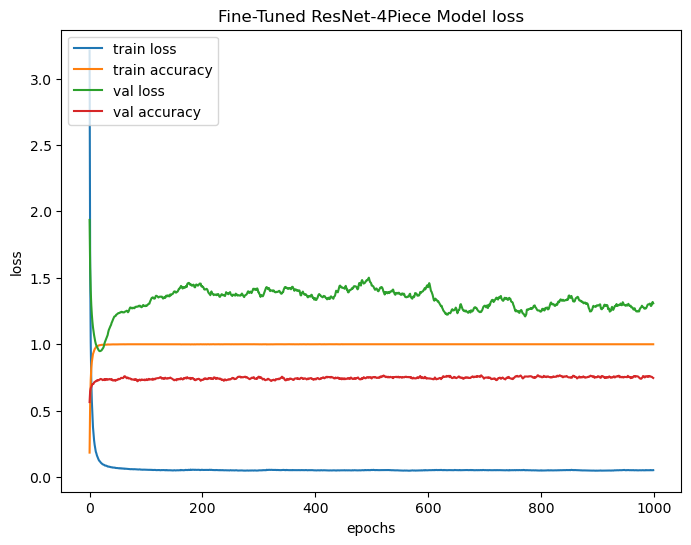

In [92]:
plot_train_loss(history, 'Fine-Tuned ResNet-4Piece Model')

### Model Evaluation

#### On Train Data

Now, after the model is being trained, we will look at the performance of the model on the training set.

In [93]:
train_preds = model1.predict(fine_tune_data_train_red)

 56/475 [==>...........................] - ETA: 1s

2022-10-08 14:48:41.403552: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


475/475 [==============================] - 1s 3ms/step


In [94]:
train_pred_labels = np.argmax(train_preds, axis=-1)

In [95]:
train_pred_labels

array([ 1, 13, 13, ...,  3,  9,  9])

In [96]:
np.sum(train_pred_labels == train_labels['label'])

15197

Looking at the misclassified images to get a better idea about what features the model is unable to capture.

In [97]:
mis_train_data = train_labels[train_pred_labels != train_labels['label']]
mis_train_data

,id,images,label
9198,9682,./Data/train/train/9682.tif,12
12255,12896,./Data/train/train/12896.tif,9
14569,15333,./Data/train/train/15333.tif,7


In [98]:
precision, recall, fscore, support = score(train_labels['label'], train_pred_labels)
pd.DataFrame({
    'precision': precision,
    'recall': recall,
    'fscore': fscore,
    'support': support
})

,precision,recall,fscore,support
0,0.997959,1.000000,0.998979,978
1,1.000000,1.000000,1.000000,925
2,1.000000,1.000000,1.000000,925
3,1.000000,1.000000,1.000000,947
4,0.998926,1.000000,0.999463,930
5,1.000000,1.000000,1.000000,962
6,1.000000,1.000000,1.000000,998
7,1.000000,0.998905,0.999452,913
8,1.000000,1.000000,1.000000,1005
9,1.000000,0.998951,0.999475,953


#### On Train-Test Data

In [99]:
test_preds = model1.predict(fine_tune_data_test_red)

25/25 [==============================] - 0s 2ms/step


In [100]:
test_pred_labels = np.argmax(test_preds, axis=-1)

In [101]:
test_pred_labels

array([11,  8,  0,  1, 11,  9, 13, 12, 14, 10,  6, 15,  7, 14,  1, 15,  0,
        9,  6, 10,  8, 14,  3, 12,  6,  0,  3, 14,  3,  3, 11,  1,  9,  2,
       13,  8,  4, 15, 11,  9,  6, 12, 14,  2,  5, 14,  3,  0, 13,  4,  0,
       10, 14,  0, 11, 14, 10,  6,  9,  2, 15, 13,  2, 11,  6, 12,  8,  0,
        6,  3,  9,  4, 12,  0,  8,  6,  7,  0, 12, 11, 11,  0, 12, 12,  9,
        8, 13, 13,  0, 13, 10, 11,  4, 10,  1,  7, 11,  8, 13, 10,  3, 13,
       13,  9,  7, 14,  8,  2,  5, 15,  7,  5,  9,  4, 12, 12, 12, 13, 11,
        6, 13,  1,  0,  4,  1,  5, 10, 12,  0, 11,  3,  1,  6,  1,  6,  9,
       14, 10,  7,  2, 10,  8, 11, 12,  8,  5,  8,  9,  2, 13, 15, 14,  4,
       14,  4,  9,  4, 14,  7,  7,  8,  4,  4, 10, 13,  8,  8,  4,  8,  8,
       13,  6,  3, 11,  7, 12, 10, 14, 14,  8,  6, 11, 13, 11,  6, 13,  4,
       14,  1,  7, 15,  0,  3,  0, 10, 13,  5, 10, 11, 11, 10, 11, 13,  1,
        9,  5, 13, 14, 12,  1,  4,  8, 14,  6, 13,  5,  4, 12,  8,  0,  9,
       13,  5,  0,  7, 10

In [102]:
np.sum(test_pred_labels == test_labels['label'])

596

In [103]:
mis_train_data = test_labels[test_pred_labels != test_labels['label']]
mis_train_data

,id,images,label
2,33,./Data/train/train/33.tif,6
4,65,./Data/train/train/65.tif,14
7,100,./Data/train/train/100.tif,10
9,138,./Data/train/train/138.tif,1
15,239,./Data/train/train/239.tif,11
...,...,...,...
779,15568,./Data/train/train/15568.tif,9
785,15621,./Data/train/train/15621.tif,15
788,15687,./Data/train/train/15687.tif,12
792,15735,./Data/train/train/15735.tif,5


In [104]:
precision, recall, fscore, support = score(test_labels['label'], test_pred_labels)
pd.DataFrame({
    'precision': precision,
    'recall': recall,
    'fscore': fscore,
    'support': support
})

,precision,recall,fscore,support
0,0.672131,0.759259,0.713043,54
1,0.642857,0.613636,0.627907,44
2,0.904762,0.883721,0.894118,43
3,0.866667,0.847826,0.857143,46
4,0.750000,0.833333,0.789474,36
5,0.634146,0.520000,0.571429,50
6,0.909091,0.869565,0.888889,46
7,0.857143,0.807692,0.831683,52
8,0.850000,0.944444,0.894737,54
9,0.825000,0.702128,0.758621,47


In [105]:
np.mean(fscore)

0.7451547688021714

#### On Validation Data

Generating Predictions for the Validation Set

In [106]:
validation_data = pd.DataFrame({'images':['./Data/validation/validation/'+name for name in os.listdir('./Data/validation/validation/')]})
validation_data['id'] = [name.split('.')[0] for name in os.listdir('./Data/validation/validation/')]
validation_data['label'] = -1 # Simply added to prevent re-writing code
validation_data.sort_values(by=['id'], inplace=True)
validation_data

,images,id,label
850,./Data/validation/validation/17801.tif,17801,-1
898,./Data/validation/validation/17802.tif,17802,-1
852,./Data/validation/validation/17803.tif,17803,-1
798,./Data/validation/validation/17804.tif,17804,-1
750,./Data/validation/validation/17805.tif,17805,-1
...,...,...,...
246,./Data/validation/validation/18696.tif,18696,-1
211,./Data/validation/validation/18697.tif,18697,-1
760,./Data/validation/validation/18698.tif,18698,-1
787,./Data/validation/validation/18699.tif,18699,-1


In [107]:
fine_tune_data_validation = np.load('./Data/ResNet-4P-validation-precompute/whole_validation_data_precomp.npy')

In [108]:
fine_tune_data_validation.shape

(900, 5, 2048)

In [109]:
fine_tune_data_validation_red = np.zeros((fine_tune_data_validation.shape[0], 5, N_COMPS))
for i in range(5):
    fine_tune_data_validation_red[:,i,:] = pcas[i].transform(fine_tune_data_validation[:,i,:])

In [110]:
valid_preds = model1.predict(fine_tune_data_validation_red)

29/29 [==============================] - 0s 3ms/step


2022-10-08 14:48:43.153770: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [111]:
valid_pred_labels = np.argmax(valid_preds, axis=-1)

### Submission

For Kaggle Submission

In [112]:
submission_data = pd.DataFrame({'id':list(range(17801, 18701))})
submission_data['label'] = valid_pred_labels
submission_data

,id,label
0,17801,8
1,17802,6
2,17803,4
3,17804,8
4,17805,3
...,...,...
895,18696,7
896,18697,12
897,18698,8
898,18699,4


In [113]:
submission_data.to_csv('./Submissions/submission-resnet-4p-PCA.csv', index=False)